# Logistic regression with pystan

In this notebook, we will apply logistic regression to the Palmer Penguins dataset using pystan.

## 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az
import stan

In [2]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

We will be working with PyMC last version:

## 1. Data Exploration

Firstly we load the data:

In [3]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


There are 3 reprented species of pinguins: Adelie, Gentoo and Chinstrap. The species variable will be our dependent variable.

<BarContainer object of 3 artists>

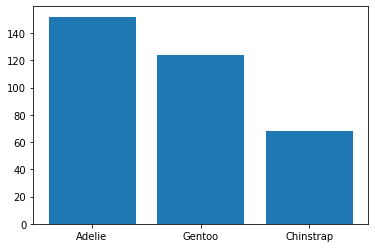

In [4]:
species_counts = dict(penguins['species'].value_counts())
plt.bar(species_counts.keys(), species_counts.values())

We are going to consider four variables as independent variables: 
- `bill_length_mm`
- `bill_depth_mm`
- `flipper_length_mm`
- `body_mass_g`

In [5]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


An easy and intuitive way of taking a first glance to our data is by doing a `seaborn` scatter matrix:

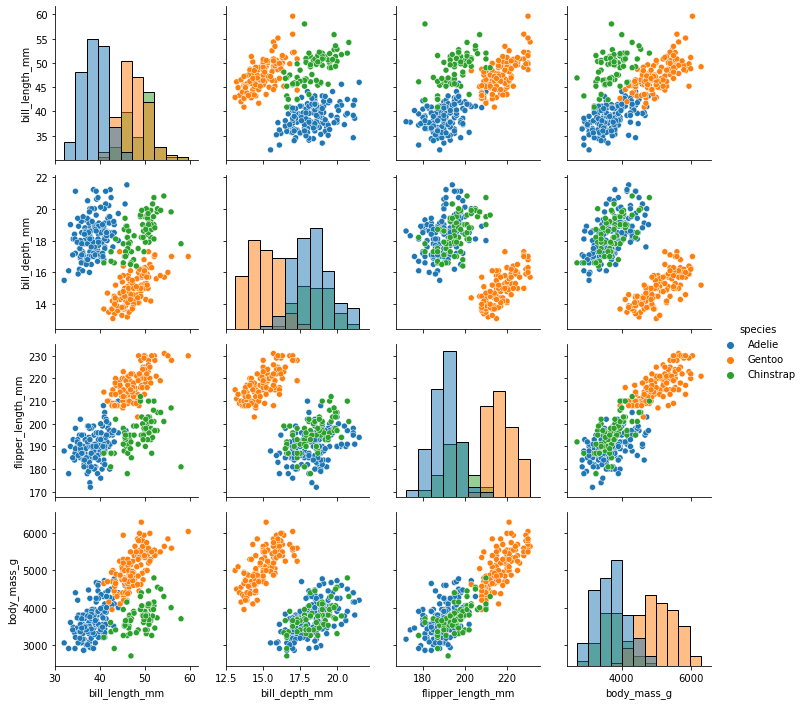

In [6]:
g = sns.PairGrid(penguins, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 1. Binary univariate classification

Again, we start by the most simple case, a two-class classification. We will just consider species `Adelie` and `Chinstrap`, i.e., $y \in \{0,1\}$. Again, here we will employ just independent variable, `flipper_length_mm`, i.e., $x \in \mathbb R$.

In [21]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y_0 = ((p1['species'] == species[0])*1).values
N=len(y_0)
ind_vars = 'flipper_length_mm'
x_0 = p1[ind_vars].values.reshape((N, 1))

We can observe the distribution of our two 1-dimensional clusters with a violin plot:

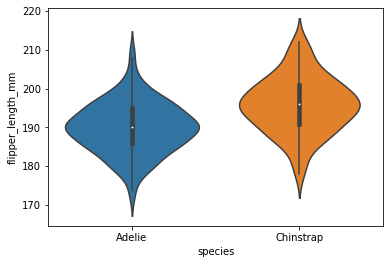

In [23]:
sns.violinplot(data=p1[['species','flipper_length_mm']], x='species', y='flipper_length_mm')
plt.show()

Now that we have the data, we need to specify the model, that is, our prior distribution and likelihood. As the likelihood, we will chose a Bernoulli $(p= \theta )$ distribution, and for the priors we select $N(\mu=0, \sigma=10)$ for both $\alpha$ and $\beta$.

In [44]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [45]:
data = {                                                                                             
    'N': N,                                                                                        
    'K': 1,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

In [46]:
posterior = stan.build(code, data=data, random_seed=1)



Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [49]:
fit = posterior.sample(num_chains=4, num_samples=1000)



Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  32% (2600/8000)
Sampling:  50% (4000/8000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000134 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000117 seconds
  1000 transitions using 10 leapfrog steps pe

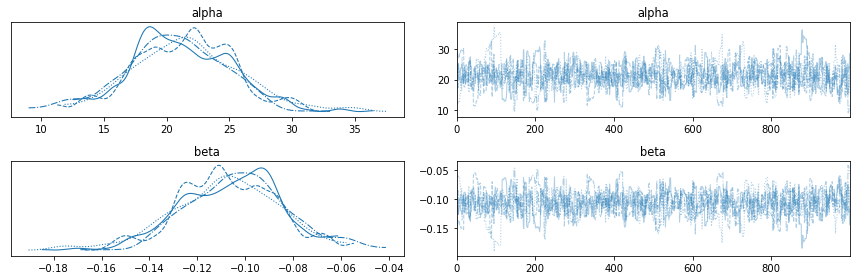

In [50]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()

Now we can plot the data together with the fitted logistic curve. Firstly we make some format adjustments:

In [113]:
#trace_pymc_0 = {}
#
#theta_mc = np.array(trace_0.posterior['theta'])
#trace_pymc_0['theta'] = theta_mc.reshape(theta_mc.shape[0]*theta_mc.shape[1], theta_mc.shape[2])
#trace_pymc_0['bd'] = np.array(trace_0.posterior['bd']).flatten()

In [53]:
#plt.figure(figsize=(12,4))
#theta = trace_pymc_0['theta'].mean(axis=0)
#idx = np.argsort(x_0.flatten())
#plt.plot(x_0.flatten()[idx], theta[idx], color='b', lw=3);
#plt.axvline(trace_pymc_0['bd'].mean(), ymax=1, color='r')
#bd_hpd = az.hdi(trace_pymc_0['bd'], hdi_prob=.95)
#plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)
#
#plt.plot(x_0, y_0, 'o', color='k')
#theta_hpd = az.hdi(trace_pymc_0['theta'], hdi_prob=.95)[idx]
#plt.fill_between(x_0.flatten()[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)
#
#plt.xlabel('flipper_length_mm', fontsize=16)
#plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

Where the fitted sigmoid function is the blue line and decision boundary is the red line, with their corresponding 95% HDIs. From this plot is easy to interpret the classification for each data point; points at the right side of the decision boundary will be classified as class 1 (Adelie), and those at the left side will be classified as class 0 (Chinstrap). Black dots are positioned along the y-axis according to their real class.

## 2. Multinomial logistic regression

Finally, for the dependent variable we are going to use the three classes (Adelie, Gentoo and Chinstrap), and the four considered dependent variables. We are also going to standardize the data, since this will help the sampler to run more efficiently:

In [54]:
y_s = pd.Categorical(penguins['species']).codes
N = len(y_s)
x_n = penguins.columns[1:]
x_s = penguins[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)

In [55]:
(y_s.shape, x_s.shape)

((342,), (342, 4))

Now we will make a few changes in the model definition with respect to the rest of the experiments. Besides of the correspondent changes in the `shape` parameter when defining the priors of $\alpha$ and $\beta$, we have employed the `softmax` from `math` in PyMC, which embodies a generalization of the logistic function to multiple dimensions.

In [56]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta;                                                                            
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,2);                                                                 
                                                                                                   
  y ~ categorical_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [57]:
data = {                                                                                             
    'N': N,                                                                                        
    'K': 4,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

In [58]:
posterior = stan.build(code, data=data, random_seed=1)



Building: 0.3s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.2s
Building: 5.3s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.2s
Building: 

In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:57:23: warning: comparison of integers of different signs: 'int' and 'std:

Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/hmm_check.hpp:33:7: warning: unused variable 'n_transitions' [-Wunused-variable]
  int n_transitions = log_omegas.cols() - 1;
      ^


Building: 13.2s
Building: 13.3s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:39: warning: lambda capture 'a' is not used [-Wunused-lambda-capture]
  return make_callback_var(beta_val, [a, b, digamma_ab](auto& vi) mutable

Building: 16.0s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.8s
Building: 17.9s
Building: 18.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:121:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/gp_matern52_cov.hpp:304:10: warning: unused variable 'neg_root_5' [-Wunused

Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:188:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/log_mix.hpp:86:13: warning: unused variable 'N' [-Wunused-variable]
  const

Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 20.0s
Building: 20.1s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:124:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_hea

Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:158:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                           ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:94:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka

Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.5s
Building: 25.6s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.6s
Building: 26.7s
Building: 26.8s
Building: 26.9s
Building: 27.1s
Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.6s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.3s
Building: 28.4s
Building: 28.5s
Building: 28.6s
Building: 28.8s
Building: 28.9s
Building

In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/dae.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_integrator.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_service.hpp:93:28: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'int' [-Wsign-compare]
    for (size_t is = 0; is < ns; +

Building: 29.3s
Building: 29.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:30:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/finite_diff_hessian_auto.hpp:61:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'int' [-Wsign-compare]
  for (size_t i = 0; i < d; ++i) {
                     ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/finite_diff_hessian_auto.hpp:69:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long

Building: 29.6s
Building: 29.7s
Building: 29.8s
Building: 29.9s
Building: 30.1s
Building: 30.2s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^


Building: 30.3s
Building: 30.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:41:21: warning: comparison of integers of different signs: 'int' and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < M; i++) {
                  ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7:

Building: 30.6s
Building: 30.7s
Building: 30.8s
Building: 30.9s
Building: 31.1s
Building: 31.2s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 31.3s
Building: 31.4s
Building: 31.6s
Building: 31.7s
Building: 31.8s
Building: 32.0s
Building: 32.1s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.6s
Building: 32.7s
Building: 32.8s
Building: 32.9s
Building: 33.0s
Building: 33.1s
Building: 33.3s
Building: 33.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:308:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_lccdf.hpp:78:13: warning: unused variable 'size_sigma' [-Wunused-variable]
  const int size_sigma = stan::math::size(sigma);
            ^
In 

Building: 33.5s
Building: 33.6s
Building: 33.7s
Building: 33.8s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:7:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<double>::size_type' (aka 'unsigned long') [-Wsign-compare]
      for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
                                         ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
             real_iter < val_i->second.first.size();
             ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5e

Building: 34.0s
Building: 34.1s
Building: 34.2s
Building: 34.3s
Building: 34.4s
Building: 34.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:274:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:528:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < col_idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/https

Building: 34.7s
Building: 34.8s
Building: 35.0s
Building: 35.1s
Building: 35.2s
Building: 35.3s
Building: 35.4s
Building: 35.6s
Building: 35.7s
Building: 35.8s
Building: 35.9s
Building: 36.0s
Building: 36.2s
Building: 36.3s
Building: 36.4s
Building: 36.5s
Building: 36.6s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_subtraction.hpp:84:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += 

Building: 36.8s
Building: 36.9s
Building: 37.0s
Building: 37.1s
Building: 37.2s
Building: 37.3s
Building: 37.5s
Building: 37.6s
Building: 37.7s
Building: 37.8s
Building: 37.9s
Building: 38.0s
Building: 38.1s
Building: 38.3s
Building: 38.4s
Building: 38.5s
Building: 38.6s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/grad_inc_beta.hpp:45:43: note: in instantiation of function template specialization 'stan::math::operator+<int, nullptr>' requested here
    gr

Building: 38.7s
Building: 38.9s
Building: 39.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/trigamma.hpp:63:31: note: in instantiation of function template specialization 'stan::math::operator+<double, nullptr>' requested here
    val

Building: 39.1s
Building: 39.2s
Building: 39.3s
Building: 39.5s
Building: 39.6s
Building: 39.7s
Building: 39.8s
Building: 39.9s
Building: 40.0s
Building: 40.2s
Building: 40.3s
Building: 40.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 40.5s
Building: 40.6s
Building: 40.8s
Building: 40.9s
Building: 41.0s
Building: 41.1s
Building: 41.2s
Building: 41.3s
Building: 41.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 41.6s
Building: 41.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/inc

Building: 41.8s
Building: 41.9s
Building: 42.0s
Building: 42.2s
Building: 42.3s
Building: 42.4s
Building: 42.5s
Building: 42.7s
Building: 42.8s
Building: 42.9s
Building: 43.0s
Building: 43.1s
Building: 43.2s
Building: 43.4s
Building: 43.5s
Building: 43.6s
Building: 43.7s
Building: 43.8s
Building: 43.9s
Building: 44.1s
Building: 44.2s
Building: 44.3s
Building: 44.4s
Building: 44.5s
Building: 44.6s
Building: 44.8s
Building: 44.9s
Building: 45.0s
Building: 45.1s
Building: 45.2s
Building: 45.4s
Building: 45.5s
Building: 45.8s
Building: 45.9s
Building: 46.0s
Building: 46.2s
Building: 46.3s
Building: 46.4s
Building: 46.5s
Building: 46.6s
Building: 46.8s
Building: 46.9s
Building: 47.0s
Building: 47.1s
Building: 47.2s
Building: 47.3s
Building: 47.4s
Building: 47.6s
Building: 47.7s
Building: 47.8s
Building: 47.9s
Building: 48.0s
Building: 48.1s
Building: 48.2s
Building: 48.4s
Building: 48.5s
Building: 48.6s
Building: 48.7s
Building: 48.8s
Building: 48.9s
Building: 49.1s
Building: 49.2s
Building

62 warnings generated.


Building: 58.6s
Building: 58.7s
Building: 58.8s
Building: 59.0s
Building: 59.1s


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/fht5ehkq/model_fht5ehkq.o' means the weak symbol cannot

Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_k4zzttdv/model_fht5ehkq.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


RuntimeError: Error calling get_param_names: `Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=X; position=1; dims declared=(219,4); dims found=(219,1) (in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_zywzm2ua/model_fht5ehkq.stan', line 6, column 2 to column 16)`

In [59]:
fit = posterior.sample(num_chains=2, num_samples=1000)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!


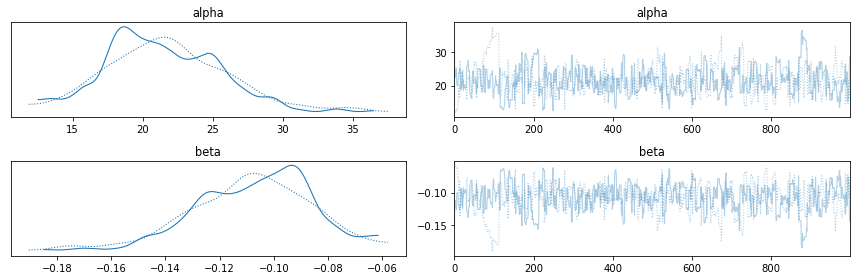

In [60]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()